x_test:
[[0.087667], [0.08804], [0.103226], [0.1172], [0.069104]]

Accuracy: 1.0


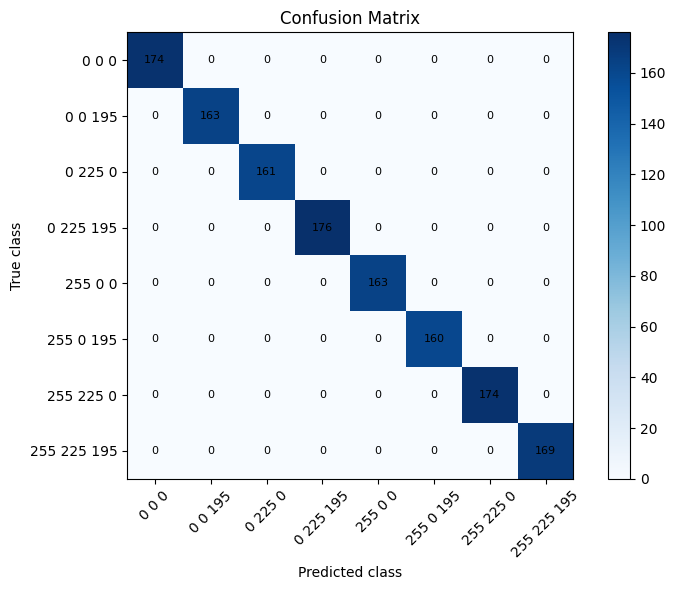

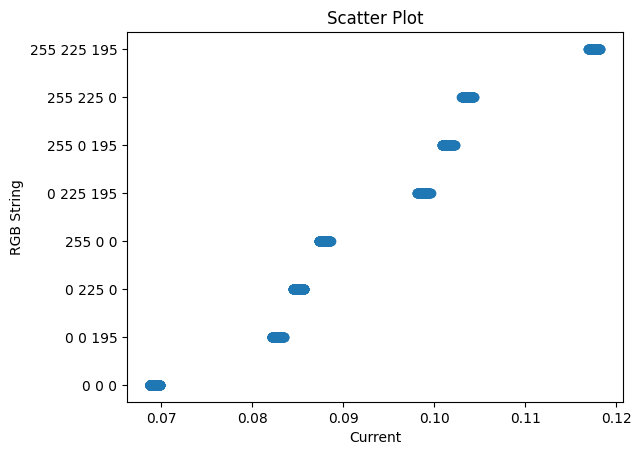

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Read the data file
df = pd.read_csv("./labeled_dataset_2024.05.24-03h39m42s.csv", sep=',')
# print(df)

df = df.sort_values(by='current')

# Create a list with current and RGB values as a string
x = []
y = []
for index, row in df.iterrows():
  rgb_string = ' '.join([str(int(val)) for val in row[['R', 'G', 'B']]])  # Join RGB values with spaces
  x.append([row['current']])
  y.append(rgb_string)
  
# print(x)
# print(y)

# # Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
# print('x_train:'); print(x_train[:5])
# print('y_train:'); print(y_train[:5])
print('x_test:'); print(x_test[:5])
# print('y_test:'); print(y_test[:5])

# Create a decision tree classifier object
clf = tree.DecisionTreeClassifier()

# Train the decision tree model
clf.fit(x_train, y_train)

# Make predictions on unseen data
predictions = clf.predict(x_test)

# Evaluate the model (accuracy in this case)
accuracy = accuracy_score(y_test, predictions)
print("\nAccuracy:", accuracy)

# Get the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Visualize confusion matrix (using matplotlib)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')  # Adjust colormap as desired
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)  # Rotate class labels for readability
plt.yticks(tick_marks, np.unique(y_test))

# Add labels and title
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion Matrix')

# Add text with counts on confusion matrix
for i in range(len(cm)):
  for j in range(len(cm[i])):
    plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

plt.scatter(x, clf.predict(x))
plt.xlabel('Current')
plt.ylabel('RGB String')
plt.title('Scatter Plot')
plt.show()


import pickle

# Save the classifier
with open('classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [3]:
import signal
import serial
import pickle

# Load the classifier later
with open('classifier.pkl', 'rb') as f:
    clf = pickle.load(f)

def handle_sigint(sig, frame):
    exit(0)  # Exit gracefully
signal.signal(signal.SIGINT, handle_sigint)  # Register the signal handler

def log_file_write_line(line):
    pass

# Define serial port settings
port = "/dev/ttyACM0"
timeout = 0.010 # 100ms should be enough

# Open serial port connection
try:
    serial = serial.Serial(port, timeout=timeout)
except serial.SerialException as e:
    print(f"Error connecting to serial port: {e}")
    exit()

r = 0
g = 0
b = 0
rx_new_data = False

while True:
    try:
        # Read data from serial port
        uart_data = serial.readline().decode('utf-8').rstrip()
        if uart_data:
            # sometimes the rx UART values are not ok (like at startup)
            # this try except will skip that case
            try:
                rgb = uart_data.split(',')
                target_current = float(rgb[0])
                rx_new_data = True
            except Exception as e:
                pass

            # target_current must be < 1.0, otherwise the data is wrong and usually happens at startup
            if rx_new_data and target_current < 1.0:
                
                prediction = clf.predict([[target_current]])
                rgb = prediction[0].split(' ')
                
                r = int(float(rgb[0]))
                g = int(float(rgb[1]))
                b = int(float(rgb[2]))
                
                print(r, g, b)
                
                # echo the RGB values to the observer board
                # first byte '2' is command to change LED value
                string_to_send = f'{2},{r},{g},{b}'
                serial.write(bytes(string_to_send, "utf-8"))
            
            rx_new_data = False
            
            # reset any bytes on the input buffer
            if serial.in_waiting:
                serial.reset_input_buffer()

    except KeyboardInterrupt:
        break



Error connecting to serial port: [Errno 2] could not open port /dev/ttyACM0: [Errno 2] No such file or directory: '/dev/ttyACM0'


AttributeError: module 'serial' has no attribute 'readline'

: 

In [1]:
import pickle

# Load the classifier later
with open('classifier.pkl', 'rb') as f:
    clf = pickle.load(f)

# Extract the tree structure
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
value = clf.tree_.value

print(f"Number of nodes: {n_nodes}")
print(f"Children left: {children_left}")
print(f"Children right: {children_right}")
print(f"Feature indices: {feature}")
print(f"Thresholds: {threshold}")
print(f"Values: {value}")

Number of nodes: 15
Children left: [ 1 -1  3  4 -1  6  7  8 -1 -1 11 -1 -1 -1 -1]
Children right: [ 2 -1 14  5 -1 13 10  9 -1 -1 12 -1 -1 -1 -1]
Feature indices: [ 0 -2  0  0 -2  0  0  0 -2 -2  0 -2 -2 -2 -2]
Thresholds: [ 0.076022  -2.         0.1106675  0.0839875 -2.         0.102643
  0.0933505  0.086526  -2.        -2.         0.100221  -2.
 -2.        -2.        -2.       ]
Values: [[[693. 673. 655. 656. 675. 653. 673. 682.]]

 [[693.   0.   0.   0.   0.   0.   0.   0.]]

 [[  0. 673. 655. 656. 675. 653. 673. 682.]]

 [[  0. 673. 655. 656. 675. 653. 673.   0.]]

 [[  0. 673.   0.   0.   0.   0.   0.   0.]]

 [[  0.   0. 655. 656. 675. 653. 673.   0.]]

 [[  0.   0. 655. 656. 675. 653.   0.   0.]]

 [[  0.   0. 655.   0. 675.   0.   0.   0.]]

 [[  0.   0. 655.   0.   0.   0.   0.   0.]]

 [[  0.   0.   0.   0. 675.   0.   0.   0.]]

 [[  0.   0.   0. 656.   0. 653.   0.   0.]]

 [[  0.   0.   0. 656.   0.   0.   0.   0.]]

 [[  0.   0.   0.   0.   0. 653.   0.   0.]]

 [[  0.   0.

In [14]:
from sklearn.tree import export_graphviz
import graphviz

feature_names = ['current']
class_names = ['0 0 0', '0 0 195', '0 225 0', '255 0 0', 'e', 'f', 'g', 'h']

# Export the decision tree to a DOT file
dot_data = export_graphviz(clf, out_file=None,
                           feature_names=['current'],
                           class_names=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                           filled=True, rounded=True,
                           special_characters=True)

# Use graphviz to create a visualization from the DOT data
graph = graphviz.Source(dot_data)
# graph.render("decision_tree")  # Save as PDF
graph.view()  # Display the tree visualization


'Source.gv.pdf'

Gtk-Message: 10:58:37.044: Failed to load module "canberra-gtk-module"
Gtk-Message: 10:58:37.045: Failed to load module "canberra-gtk-module"
